In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import sys
print(sys.executable)


/home/onizuka/Documents/Project M1/venv/bin/python3.10


In [6]:
socket_data= pd.read_csv('final_data.csv')
socket_data.columns

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'MACD_Line',
       'Signal_Line', 'RSI', 'BB_Lower', 'BB_Middle', 'BB_Upper', 'ADX',
       'direction_macd', 'direction_rsi', 'direction'],
      dtype='object')

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Separate features (X) and target (y)
X = socket_data.drop(columns=['direction'])  # Exclude the target column
y = socket_data['direction']  # Target column

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1229
         1.0       1.00      1.00      1.00       982

    accuracy                           1.00      2211
   macro avg       1.00      1.00      1.00      2211
weighted avg       1.00      1.00      1.00      2211



In [8]:
# Get feature importances
importances = rf_model.feature_importances_
feature_names = X.columns

# Display feature importances
for feature, importance in zip(feature_names, importances):
    print(f"{feature}: {importance:.4f}")


Adj Close: 0.0017
Close: 0.0027
High: 0.0022
Low: 0.0023
Open: 0.0024
Volume: 0.0013
MACD_Line: 0.0104
Signal_Line: 0.0212
RSI: 0.0962
BB_Lower: 0.0054
BB_Middle: 0.0043
BB_Upper: 0.0034
ADX: 0.0098
direction_macd: 0.2894
direction_rsi: 0.5474


In [9]:
# Selecting only important features
selected_features = ['direction_rsi', 'direction_macd', 'RSI', 'Signal_Line']
X_selected = socket_data[selected_features]

# Split data with selected features
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Train the RandomForestClassifier with selected features
rf_model.fit(X_train, y_train)

# Evaluate again
y_pred = rf_model.predict(X_test)
print("Accuracy with selected features:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy with selected features: 1.0
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1229
         1.0       1.00      1.00      1.00       982

    accuracy                           1.00      2211
   macro avg       1.00      1.00      1.00      2211
weighted avg       1.00      1.00      1.00      2211



In [10]:
print(y.value_counts())


direction
0.0    6147
1.0    4906
Name: count, dtype: int64


In [11]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf_model, X_selected, y, cv=5, scoring='accuracy')
print("Cross-validation scores:", scores)
print("Mean cross-validation accuracy:", scores.mean())


Cross-validation scores: [1. 1. 1. 1. 1.]
Mean cross-validation accuracy: 1.0


In [12]:
correlation_matrix = socket_data.corr()
print(correlation_matrix['direction'].sort_values(ascending=False))


direction_rsi     1.000000
direction         1.000000
direction_macd    0.747648
RSI               0.016845
Volume           -0.019941
MACD_Line        -0.038548
Adj Close        -0.041527
Low              -0.042751
Open             -0.042983
Close            -0.043035
High             -0.043131
BB_Upper         -0.046664
BB_Middle        -0.046984
BB_Lower         -0.047307
ADX              -0.068130
Signal_Line      -0.114772
Name: direction, dtype: float64


In [13]:
# Remove leaky features
X_revised = socket_data.drop(columns=['direction', 'direction_rsi', 'direction_macd'])

# Split data again
X_train, X_test, y_train, y_test = train_test_split(X_revised, y, test_size=0.2, random_state=42)

# Retrain RandomForestClassifier
rf_model.fit(X_train, y_train)

# Evaluate
y_pred = rf_model.predict(X_test)
print("Accuracy without leaky features:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy without leaky features: 0.9235639981908639
Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.93      0.93      1229
         1.0       0.92      0.91      0.91       982

    accuracy                           0.92      2211
   macro avg       0.92      0.92      0.92      2211
weighted avg       0.92      0.92      0.92      2211



In [14]:
importances = rf_model.feature_importances_
feature_names = X_revised.columns
for feature, importance in zip(feature_names, importances):
    print(f"{feature}: {importance:.4f}")


Adj Close: 0.0433
Close: 0.0376
High: 0.0364
Low: 0.0377
Open: 0.0361
Volume: 0.0367
MACD_Line: 0.1027
Signal_Line: 0.1419
RSI: 0.2886
BB_Lower: 0.0527
BB_Middle: 0.0557
BB_Upper: 0.0506
ADX: 0.0801


In [15]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [16]:
# Re-train the model with the best parameters
optimized_rf_model = RandomForestClassifier(
    max_depth=20, 
    min_samples_leaf=1, 
    min_samples_split=2, 
    n_estimators=300, 
    random_state=42
)

optimized_rf_model.fit(X_train, y_train)

# Evaluate on test set
y_pred_optimized = optimized_rf_model.predict(X_test)

# Performance metrics
print("Optimized Model Accuracy:", accuracy_score(y_test, y_pred_optimized))
print("Classification Report:\n", classification_report(y_test, y_pred_optimized))


Optimized Model Accuracy: 0.9249208502939846
Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.93      0.93      1229
         1.0       0.92      0.91      0.92       982

    accuracy                           0.92      2211
   macro avg       0.92      0.92      0.92      2211
weighted avg       0.92      0.92      0.92      2211



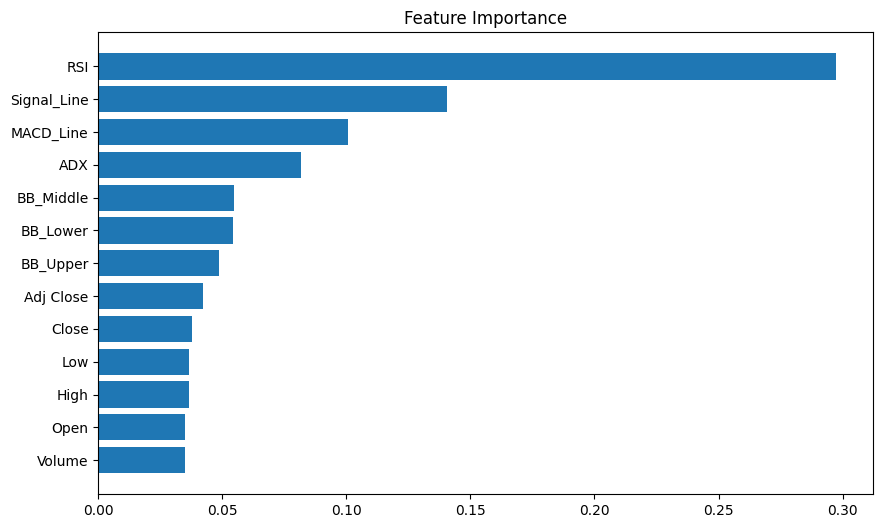

In [17]:
import matplotlib.pyplot as plt

# Feature importances
importances = optimized_rf_model.feature_importances_
sorted_indices = importances.argsort()

# Plot
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_indices)), importances[sorted_indices], align='center')
plt.yticks(range(len(sorted_indices)), X_revised.columns[sorted_indices])
plt.title("Feature Importance")
plt.show()


## Prepare training and test sets

In [8]:
target_column = 'direction'
X=data_copy.drop(target_column , axis=1)
y=data_copy[target_column]

In [9]:
X.shape

(11026, 22)

In [10]:
y.shape

(11026,)

In [11]:
from sklearn.preprocessing import MinMaxScaler

# Scale features to [0, 1]
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split with scaled data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)


## LSTM

In [59]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout


2024-12-27 18:05:23.098167: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-27 18:05:23.102112: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-27 18:05:23.112673: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735319123.129413    8632 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735319123.133908    8632 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-27 18:05:23.150407: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [60]:
scalar = MinMaxScaler()

X_train_scaled = scalar.fit_transform(X_train)
X_test_scaled = scalar.fit_transform(X_test)


In [61]:
X_train_reshaped = np.expand_dims(X_train_scaled, axis=1)
X_test_reshaped = np.expand_dims(X_test_scaled, axis=1)


In [62]:
print(X_train_reshaped.shape)
X_test_reshaped.shape


(9189, 1, 22)


(1837, 1, 22)

In [63]:
regressor = Sequential()

regressor.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape=(1, X_train_scaled.shape[1])))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.4))

regressor.add(LSTM(units = 120, activation = 'relu'))
regressor.add(Dropout(0.5))

regressor.add(Dense(units = 1))


2024-12-27 18:05:33.813877: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [64]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['accuracy'])


In [65]:
regressor.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_data=[X_test_reshaped, y_test], verbose=0)


In [66]:
loss , accuracy = regressor.evaluate(X_test_reshaped, y_test)


58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5195 - loss: 0.2494 


In [67]:
preds = regressor.predict(X_test_reshaped)


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step   


In [68]:
from sklearn.metrics import mean_squared_error


In [69]:
mean_squared_error(y_test, preds)


0.24949195981025696

## Random Forest Classifier

In [53]:
from sklearn.ensemble import RandomForestClassifier
import optuna
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit


In [44]:
def rf_algo(trial):
    # Hyperparamètres suggérés par Optuna
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 32, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_float('max_features', 0.1, 1.0)
    
    # Modèle Random Forest
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        class_weight='balanced',
        random_state=42
    )
    
    # Validation croisée avec TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)
    scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring='accuracy')
    return scores.mean()



In [45]:
# Optimisation des hyperparamètres avec Optuna
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(rf_algo, n_trials=100)


[I 2024-12-27 17:38:31,550] A new study created in memory with name: no-name-d751a43a-a378-4037-8d5a-501e1181cf34
[I 2024-12-27 17:39:00,063] Trial 0 finished with value: 0.5165251469627694 and parameters: {'n_estimators': 95, 'max_depth': 28, 'min_samples_split': 4, 'min_samples_leaf': 9, 'max_features': 0.7991019637168074}. Best is trial 0 with value: 0.5165251469627694.
[I 2024-12-27 17:39:36,604] Trial 1 finished with value: 0.5171783148269105 and parameters: {'n_estimators': 153, 'max_depth': 19, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': 0.6383440191088323}. Best is trial 1 with value: 0.5171783148269105.
[I 2024-12-27 17:40:09,580] Trial 2 finished with value: 0.5175702155453952 and parameters: {'n_estimators': 189, 'max_depth': 7, 'min_samples_split': 20, 'min_samples_leaf': 8, 'max_features': 0.7859699136734832}. Best is trial 2 with value: 0.5175702155453952.
[I 2024-12-27 17:40:11,417] Trial 3 finished with value: 0.5163945133899412 and parameters: {'n_es

In [46]:
# Résultats de l'optimisation
print("Meilleurs Hyperparamètres :", study_rf.best_params)


Meilleurs Hyperparamètres : {'n_estimators': 56, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 0.8731724677319943}


In [47]:
# Entraîner le modèle avec les meilleurs hyperparamètres
rf_model = RandomForestClassifier(**study_rf.best_params, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(max_depth=3, max_features=0.8731724677319943,
                       min_samples_leaf=4, n_estimators=56, random_state=42)

In [48]:
# Évaluation sur l'ensemble de test
y_pred = rf_model.predict(X_test)


In [49]:
# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matrice de Confusion:\n", conf_matrix)


Matrice de Confusion:
 [[445 414]
 [524 454]]


In [50]:
# Rapport de classification
class_report = classification_report(y_test, y_pred)
print("Rapport de Classification:\n", class_report)


Rapport de Classification:
               precision    recall  f1-score   support

           0       0.46      0.52      0.49       859
           1       0.52      0.46      0.49       978

    accuracy                           0.49      1837
   macro avg       0.49      0.49      0.49      1837
weighted avg       0.49      0.49      0.49      1837



In [51]:
# Précision sur le test
accuracy = accuracy_score(y_test, y_pred)
print("Précision sur le Test :", accuracy)


Précision sur le Test : 0.4893848666303756


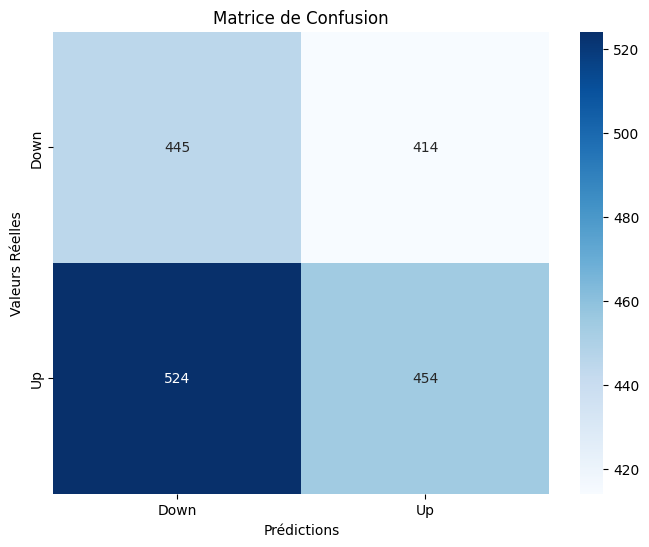

In [52]:
# Visualisation de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Up'], yticklabels=['Down', 'Up'])
plt.xlabel('Prédictions')
plt.ylabel('Valeurs Réelles')
plt.title('Matrice de Confusion')
plt.show()


## LightGBM Classifier


In [12]:
import lightgbm as lgb
from catboost import CatBoostClassifier


In [20]:
import lightgbm as lgb
import optuna
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


In [27]:
import lightgbm as lgb
import optuna
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import StratifiedKFold
import numpy as np

def objective_lgb(trial):
    # Hyperparameters to tune
    params = {
        'objective': 'binary',
        'metric': 'binary_error',
        'verbosity': -1,
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss']),
        'num_leaves': trial.suggest_int('num_leaves', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 10, 50),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-9, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-9, 10.0),
        'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10)  # Adjust weight for imbalance
    }

    # Stratified K-Fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracy_scores = []

    for train_idx, val_idx in skf.split(X_train, y_train):
        # Use numpy array indexing (not .iloc)
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Train LightGBM model
        model = lgb.LGBMClassifier(**params, random_state=42)
        model.fit(X_train_fold, y_train_fold)

        # Predict and evaluate
        y_pred = model.predict(X_val_fold)
        accuracy_scores.append(accuracy_score(y_val_fold, y_pred))

    return np.mean(accuracy_scores)  # Average accuracy from cross-validation

# Optuna study for LightGBM
study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(objective_lgb, n_trials=100)

# Get the best hyperparameters
best_params_lgb = study_lgb.best_params
print("Best LightGBM Hyperparameters:", best_params_lgb)

# Train the final model with the best hyperparameters on the full dataset
final_model = lgb.LGBMClassifier(**best_params_lgb, random_state=42)
final_model.fit(X_train, y_train)

# Predict and evaluate on the test set
y_pred = final_model.predict(X_test)
print(classification_report(y_test, y_pred))


[I 2024-12-27 19:33:34,179] A new study created in memory with name: no-name-fb3d9d84-8961-47e9-81a2-7c0aa4b65389
/tmp/ipykernel_44382/2053985657.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),
/tmp/ipykernel_44382/2053985657.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/tmp/ipykernel_44382/2053985657.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'bagging_fraction': trial.suggest_unifo

Best LightGBM Hyperparameters: {'boosting_type': 'gbdt', 'num_leaves': 74, 'max_depth': 12, 'learning_rate': 0.03963700174938088, 'feature_fraction': 0.8813268284333937, 'bagging_fraction': 0.24235438802115028, 'reg_alpha': 0.010881910135620313, 'reg_lambda': 9.3670231152851, 'scale_pos_weight': 1.0747250255111092}
              precision    recall  f1-score   support

           0       0.53      0.43      0.47      1683
           1       0.51      0.60      0.55      1625

    accuracy                           0.51      3308
   macro avg       0.52      0.52      0.51      3308
weighted avg       0.52      0.51      0.51      3308



/home/onizuka/Documents/Project M1/venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [28]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.53      0.43      0.47      1683
           1       0.51      0.60      0.55      1625

    accuracy                           0.51      3308
   macro avg       0.52      0.52      0.51      3308
weighted avg       0.52      0.51      0.51      3308

